In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from tqdm import tqdm
from random import randint
from copy import deepcopy
import pickle as pkl
import argparse

from torch import nn
from models import AutoEncoder, AutoEncoderSimple, load_model
import torch.nn.functional as F

from models import load_model
sys.path.append('../../src')
sys.path.append('../../src/vae')
sys.path.append('../../src/vae/models')
sys.path.append('../../src/dsets/cosmology')
from dset import get_dataloader
from model import init_specific_model
from losses import get_loss_f, _reconstruction_loss
from training import Trainer
from viz import viz_im_r, cshow, viz_filters
from sim_cosmology import p

sys.path.append('../../lib/trim')
# trim modules
from trim import DecoderEncoder, TrimModel
from captum.attr import *

# wavelet
from pytorch_wavelets import DTCWTForward, DTCWTInverse
from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis
from kymatio.torch import Scattering2D
from kymatio.scattering2d.filter_bank import filter_bank
from kymatio.scattering2d.utils import fft2
from colorsys import hls_to_rgb
import pywt

from PIL import Image
import urllib.request
import io


In [2]:
print(pywt.families())

['haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus', 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor']


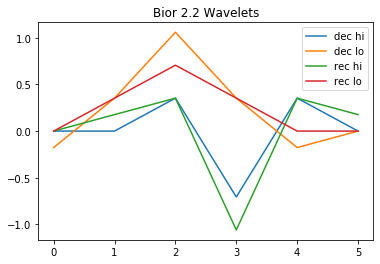

In [5]:
w=pywt.Wavelet('bior2.2')
plt.plot(w.dec_hi[::-1], label="dec hi")
plt.plot(w.dec_lo[::-1], label="dec lo")
plt.plot(w.rec_hi, label="rec hi")
plt.plot(w.rec_lo, label="rec lo")
plt.title("Bior 2.2 Wavelets")
plt.legend()
dec_hi = torch.tensor(w.dec_hi[::-1]) 
dec_lo = torch.tensor(w.dec_lo[::-1])
rec_hi = torch.tensor(w.rec_hi)
rec_lo = torch.tensor(w.rec_lo)

In [7]:
filters = torch.stack([dec_lo.unsqueeze(0)*dec_lo.unsqueeze(1),
                       dec_lo.unsqueeze(0)*dec_hi.unsqueeze(1),
                       dec_hi.unsqueeze(0)*dec_lo.unsqueeze(1),
                       dec_hi.unsqueeze(0)*dec_hi.unsqueeze(1)], dim=0)

inv_filters = torch.stack([rec_lo.unsqueeze(0)*rec_lo.unsqueeze(1),
                           rec_lo.unsqueeze(0)*rec_hi.unsqueeze(1),
                           rec_hi.unsqueeze(0)*rec_lo.unsqueeze(1),
                           rec_hi.unsqueeze(0)*rec_hi.unsqueeze(1)], dim=0)

In [14]:
def wt(vimg, levels=1):
    h = vimg.size(2)
    w = vimg.size(3)
    padded = torch.nn.functional.pad(vimg,(2,2,2,2))
    res = torch.nn.functional.conv2d(padded, filters[:,None],stride=2)
    if levels>1:
        res[:,:1] = wt(res[:,:1],levels-1)
    res = res.view(-1,2,h//2,w//2).transpose(1,2).contiguous().view(-1,1,h,w)
    return res

In [23]:
def iwt(vres, levels=1):
    h = vres.size(2)
    w = vres.size(3)
    res = vres.view(-1,h//2,2,w//2).transpose(1,2).contiguous().view(-1,4,h//2,w//2).clone()
    if levels>1:
        res[:,:1] = iwt(res[:,:1], levels=levels-1)
    res = torch.nn.functional.conv_transpose2d(res, inv_filters[:,None],stride=2)
    res = res[:,:,2:-2,2:-2]
    return res

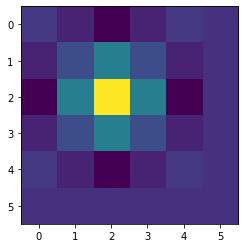

In [32]:
plt.imshow(filters[0])

In [33]:
dec_lo.unsqueeze(0).shape

torch.Size([1, 6])

In [34]:
dec_lo.shape

torch.Size([6])